In [3]:
import praw
import pandas as pd
import numpy as np
import datetime as dt
from pprint import pprint
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 8) # default plot size
import seaborn as sns
sns.set(style='whitegrid', palette='Dark2')
from wordcloud import WordCloud

nltk.download('vader_lexicon') # get lexicons data
nltk.download('punkt') # for tokenizer
nltk.download('stopwords')

client_id = '***'
client_secret = '***'
user_agent = '***'

r = praw.Reddit(user_agent=user_agent,
                client_id=client_id,
                client_secret=client_secret,
                check_for_async=False)

def scrape():
    subreddit = r.subreddit('crossfit')
    news = [*subreddit.top(limit=None)] # top posts all time
    title = [news.title for news in news]
    news = pd.DataFrame({"title": title,})
    return news

def sentiment_analysis(news):
    sid = SentimentIntensityAnalyzer()
    res = [*news['title'].apply(sid.polarity_scores)]
    sentiment_df = pd.DataFrame.from_records(res)
    news = pd.concat([news, sentiment_df], axis=1, join='inner')
    return news

def label_posts(news):
    THRESHOLD = 0.2

    conditions = [
        (news['compound'] <= -THRESHOLD),
        (news['compound'] > -THRESHOLD) & (news['compound'] < THRESHOLD),
        (news['compound'] >= THRESHOLD),
        ]

    values = ["neg", "neu", "pos"]
    news['label'] = np.select(conditions, values)

    return news

def verdeling_labels(news):
    return sns.histplot(news.label)

def custom_tokenize(text):
    stop_words = stopwords.words('english')
    # remove single quote and dashes
    text = text.replace("'", "").replace("-", "").lower()
    # split on words only
    tk = nltk.tokenize.RegexpTokenizer(r'\w+')
    tokens = tk.tokenize(text)
    # remove stop words
    words = [w for w in tokens if not w in stop_words]
    return words

def tokens_2_words(df, label):
    # subset titles based on label
    titles = df[df['label'] == label].title
    # apply our custom tokenize function to each title
    tokens = titles.apply(custom_tokenize)
    # join nested lists into a single list
    words = list(chain.from_iterable(tokens))
    return words

def wordcloud(news):
    text = " ".join(title for title in news.title)
    word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

news = scrape()
news = sentiment_analysis(news)
news = label_posts(news)

pos_words = tokens_2_words(news, 'pos')
neg_words = tokens_2_words(news, 'neg')

pos_freq = nltk.FreqDist(pos_words)
neg_freq = nltk.FreqDist(neg_words)

print(pos_freq.most_common(20))
print(neg_freq.most_common(20))


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('crossfit', 101), ('first', 69), ('today', 48), ('got', 38), ('year', 38), ('clean', 35), ('pr', 33), ('progress', 31), ('years', 31), ('months', 30), ('time', 30), ('finally', 28), ('good', 27), ('one', 24), ('ago', 24), ('happy', 23), ('muscle', 23), ('gym', 23), ('love', 21), ('3', 21)]
[('crossfit', 29), ('first', 18), ('today', 11), ('one', 11), ('time', 11), ('finally', 11), ('got', 9), ('months', 8), ('snatch', 7), ('started', 7), ('pr', 7), ('gym', 7), ('get', 7), ('muscle', 6), ('hit', 6), ('year', 6), ('years', 6), ('workout', 6), ('back', 6), ('home', 6)]


<AxesSubplot:xlabel='label', ylabel='Count'>

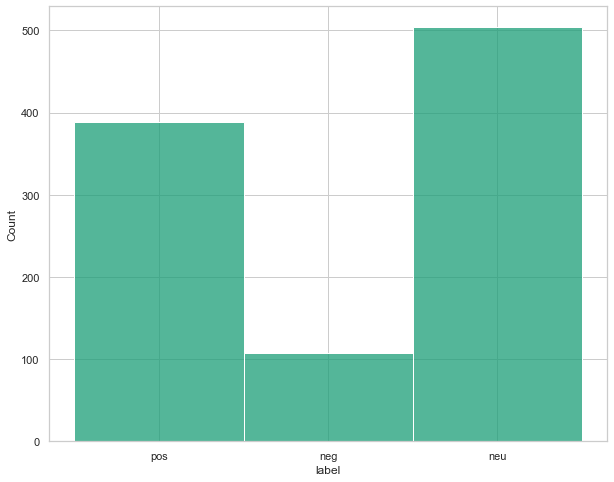

In [4]:
verdeling_labels(news)

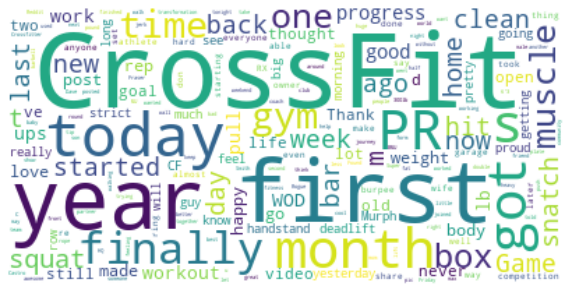

In [5]:
wordcloud(news)